In [6]:
import torch 
from torch.autograd import Variable 
from torch import optim 
from load_data import load_generate_date
from sklearn.model_selection import train_test_split
import numpy as np 
from matplotlib import pyplot as plt 
from model_attention import Encoder, Decoder
from torch import nn 
import os 
import numpy as np
hidden_size=128
learning_rate=1e-4
decoder_learning_rato=0.1
X,Y,X_word_index,Y_word_index=load_generate_date().load_data()


{'-': 1, '0': 2, '1': 3, '2': 4, '9': 5, '7': 6, '8': 7, '3': 8, '6': 9, '5': 10, '4': 11}


In [7]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.1)
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,test_size=0.15)

with open('data_test.npy','wb') as f:
    np.save(f,X_test)
    np.save(f,Y_test)

In [8]:
    
input_size=len(X_word_index)+1 # add padding character
output_size=len(Y_word_index)+2 # plus 2 for start character, end character
sos_index=len(Y_word_index)# start character
eos_index=sos_index+1# end character

Epoch:0 --- Loss:1.419877 --- Val_loss:1.392180
Epoch:1 --- Loss:0.782837 --- Val_loss:0.768766
Epoch:2 --- Loss:0.476012 --- Val_loss:0.460985
Epoch:3 --- Loss:0.282411 --- Val_loss:0.266196
Epoch:4 --- Loss:0.170952 --- Val_loss:0.166993
Epoch:5 --- Loss:0.106324 --- Val_loss:0.108490
Epoch:6 --- Loss:0.078325 --- Val_loss:0.075085
Epoch:7 --- Loss:0.058152 --- Val_loss:0.057439
Epoch:8 --- Loss:0.048268 --- Val_loss:0.045906
Epoch:9 --- Loss:0.042931 --- Val_loss:0.037983
Epoch:10 --- Loss:0.039607 --- Val_loss:0.031819
Epoch:11 --- Loss:0.035733 --- Val_loss:0.028256
Epoch:12 --- Loss:0.034954 --- Val_loss:0.025622
Epoch:13 --- Loss:0.031776 --- Val_loss:0.023499
Epoch:14 --- Loss:0.030281 --- Val_loss:0.022488
Epoch:15 --- Loss:0.030106 --- Val_loss:0.020617
Epoch:16 --- Loss:0.017326 --- Val_loss:0.010671
Epoch:17 --- Loss:0.015209 --- Val_loss:0.005559
Epoch:18 --- Loss:0.008237 --- Val_loss:0.003420
Epoch:19 --- Loss:0.006796 --- Val_loss:0.003306
Epoch:20 --- Loss:0.007034 ---

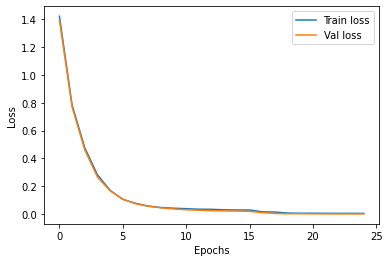

In [9]:
def forward_and_compute_loss(inputs,targets,encoder,decoder,criterion):
    batch=inputs.size()[1]
    sos=Variable(torch.ones((1,batch),dtype=torch.long)*sos_index)
    eos=Variable(torch.ones((1,batch),dtype=torch.long)*eos_index)
    decoder_inputs=torch.cat((sos,targets),dim=0)
    decoder_targets=torch.cat((targets,eos),dim=0)

    encoder_output,hidden=encoder(inputs)
    outputs,attention_weights,hidden=decoder(decoder_inputs,encoder_output,hidden)
    
    outputs=torch.transpose(torch.transpose(outputs,0,1),1,2)
    decoder_targets=torch.transpose(decoder_targets,0,1)

    loss=criterion(outputs,decoder_targets)

    return loss,outputs

def evaluate(inputs,targets,encoder,decoder,criterion):
    encoder.eval() #turn on mode evaluate
    decoder.eval()
    eval_loss,outputs=forward_and_compute_loss(inputs,targets,encoder,decoder,criterion)
    #output: T*B*output_size
    outputs=outputs.transpose(1,2)
    """
    tensor.squeeze(dim=?): remove all superfical 1 dimention from tensor
        ex:  a.size()=[3,2,1]   ===> a.shape()=[3,2] after a=a.squeeze(-1)
    """
    preds_indexs=torch.argmax(outputs,dim=-1).squeeze(-1) #T*output_size
    return eval_loss.item(),preds_indexs.data.numpy()

def train(x_train,y_train,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion):
    encoder.train()
    decoder.train()
    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()
    train_loss,outputs=forward_and_compute_loss(x_train,y_train,encoder,decoder,criterion)
    train_loss.backward()
    encoder_optimizer.step()
    decoder_optimizer.step()

    return train_loss.item()    

def plot_loss(train_loss,val_loss,n_epochs):
    plt.plot(np.arange(n_epochs),train_loss,label='Train loss')
    plt.plot(np.arange(n_epochs),val_loss,label='Val loss')
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.savefig("loss.png")

def save_model(encoder,decoder):
    #save model    
    folder="Model"
    if os.path.isdir(folder) is False:
        path=os.path.join(os.getcwd(),folder)
        os.mkdir(path)
    torch.save(encoder.state_dict(),"Model/encoder.dict")
    torch.save(decoder.state_dict(),'Model/decoder.dict')

def start_train(encoder,decoder):
    encoder_optimizer=optim.Adam(encoder.parameters(),lr=learning_rate)
    decoder_optimizer=optim.Adam(decoder.parameters(),lr=learning_rate*decoder_learning_rato)
    train_loss=[]
    val_loss=[]
    batch_size=128
    epochs=25
    x_val=torch.tensor(X_val,dtype=torch.long).transpose(0,1)
    y_val=torch.tensor(Y_val,dtype=torch.long).transpose(0,1)
    criterion=nn.CrossEntropyLoss()

    for epoch in range(epochs):
        for idx in range(len(X_train)//batch_size):
            x_train_batch=torch.tensor(
                X_train[batch_size*idx:min(batch_size*(idx+1),len(X_train))],
                dtype=torch.long
            ).transpose(0,1)

            y_train_batch=torch.tensor(
                Y_train[batch_size*idx:min(batch_size*(idx+1),len(X_train))],
                dtype=torch.long
            ).transpose(0,1)

            loss=train(x_train_batch,y_train_batch,encoder,decoder,encoder_optimizer,decoder_optimizer,criterion)
        loss1,_=evaluate(x_val,y_val,encoder,decoder,criterion)
        print("Epoch:{} --- Loss:{:5f} --- Val_loss:{:5f}".format(epoch,loss,loss1))
        train_loss.append(loss)
        val_loss.append(loss1)

    plot_loss(train_loss,val_loss,epochs)
    save_model(encoder,decoder)



def main():
    encoder=Encoder(input_size,hidden_size)
    decoder=Decoder(output_size,hidden_size,0.1)
    start_train(encoder,decoder)


if __name__=="__main__":
    main()

